In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from BuildTardisData import linear_data
from BacktestStrategy_Rev_BUSD import backtest_strategy

### Lags and delays for optimal accuracy

In [2]:
l, d = 1, 2

### Backtesting results for past 3 months data

In [3]:

def read_datasets():
    
    # Get all file names in the directory
    quotes, trades = os.listdir("D:\Quotes_BUSD"), os.listdir("D:\Trades_BUSD")
    
    # Loop through each file
    for quote, trade in zip(quotes, trades):
        
        file_path_q = os.path.join("D:\Quotes_BUSD", quote)
        file_path_t = os.path.join("D:\Trades_BUSD", trade)
            
        # Read the dataset using pandas
        df1 = pd.read_csv(file_path_q)
        df2 = pd.read_csv(file_path_t)
    
        # Yield combined dataset
        yield linear_data(df1, df2, l=l, d=d), quote[23:33]


We will be using one day's data to train the model and predict the next day.

**Assumptions:**
1. Initial Portfolio Value = $30,000
2. This includes the price to take one position at day open plus maintenance margin
3. Trade price equals Best Bid or Best ask depending on the position taken

### Profits for each trading day (Before Transaction Costs & Using Original MPB Formula) 

In [ ]:
Profits_dict = {}
comp_dict = {}
vol_dict = {}
datasets = read_datasets()
train, date = next(datasets)
for i in range(1,122):
    test, date = next(datasets)
    df = backtest_strategy(train, test, threshold=0.1, l=l, optimise=True)
    train = test
    Profits_dict[date] = df.iloc[-1,6]
    comp_dict[date] = (df.iloc[-1,5], sum(df["Trade Cost"]))
    vol_dict[date] = df.iloc[-1,3]

In [5]:
comp_dict

{'2022-12-29': (6101.099955999988, -3339.3999999999105),
 '2022-12-30': (4011.9532880000033, -3399.599999999973),
 '2022-12-31': (2952.784365999999, -1480.500000000051),
 '2023-01-01': (759.7362359999998, -698.9999999999454),
 '2023-01-02': (1406.5260160000007, -1351.3999999999905),
 '2023-01-03': (3323.918780000002, -2404.2000000000844),
 '2023-01-04': (4689.841044000002, -4151.0000000001055),
 '2023-01-05': (3591.7552160000005, -2129.800000000185),
 '2023-01-06': (2002.5287099999987, -2600.2999999999956),
 '2023-01-07': (587.7051039999999, -468.4000000000415),
 '2023-01-08': (28.498372000000003, 5.799999999999272),
 '2023-01-09': (5554.685416000005, -4745.4000000000415),
 '2023-01-10': (3604.5715019999975, -3421.9000000000196),
 '2023-01-11': (4956.621851999994, -4919.600000000057),
 '2023-01-12': (84790.38029000035, -40518.900000001675),
 '2023-01-13': (96462.77208400049, -36031.400000002206),
 '2023-01-14': (175967.9197920011, -77559.19999999733),
 '2023-01-15': (94586.97628799961,

In [6]:
profits_df = pd.DataFrame(Profits_dict.values(), Profits_dict.keys(), columns=["Profit"])
profits_df

,Profit
2022-12-29,2761.699956
2022-12-30,612.353288
2022-12-31,1472.284366
2023-01-01,60.736236
2023-01-02,55.126016
...,...
2023-04-19,81701.611914
2023-04-20,67100.604240
2023-04-21,62959.189342
2023-04-22,28542.320234


In [7]:
vol_df = pd.DataFrame(vol_dict.values(), vol_dict.keys(), columns=["Volume"])
vol_df

,Volume
2022-12-29,2628
2022-12-30,1736
2022-12-31,1274
2023-01-01,328
2023-01-02,602
...,...
2023-04-19,28970
2023-04-20,26288
2023-04-21,25802
2023-04-22,10724


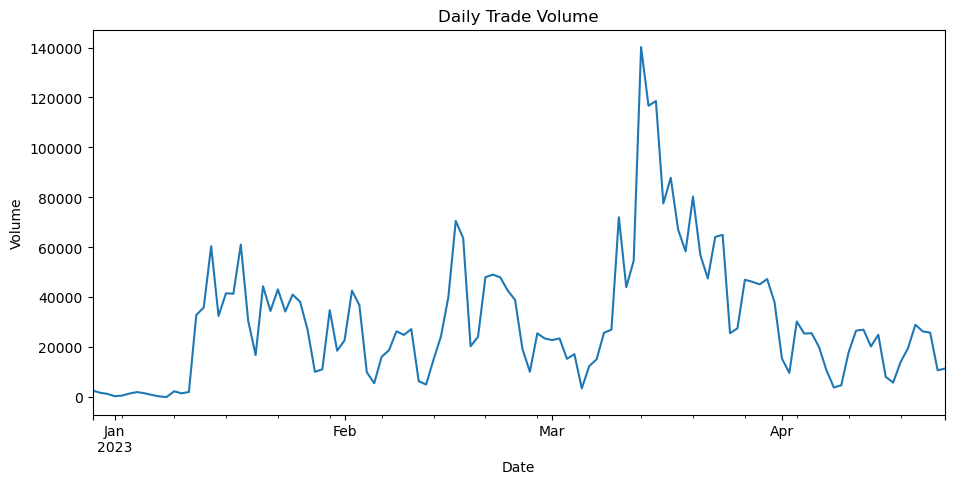

In [8]:
vol_df.index = pd.to_datetime(vol_df.index)
plt.title('Daily Trade Volume')
vol_df["Volume"].plot(figsize=(11,5))
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

### Portfolio Profit and Returns Graph

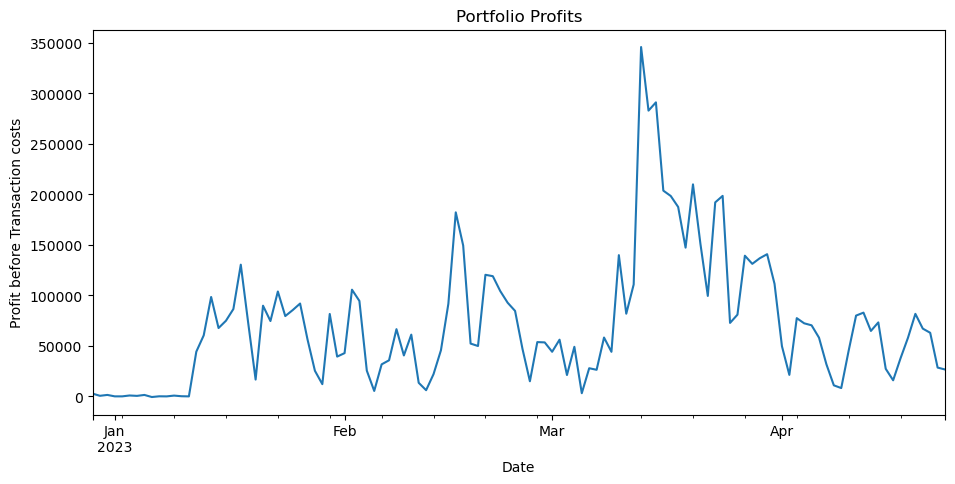

In [9]:
profits_df.index = pd.to_datetime(profits_df.index)
plt.title('Portfolio Profits')
profits_df["Profit"].plot(figsize=(11,5))
plt.xlabel('Date')
plt.ylabel('Profit before Transaction costs')
plt.show()

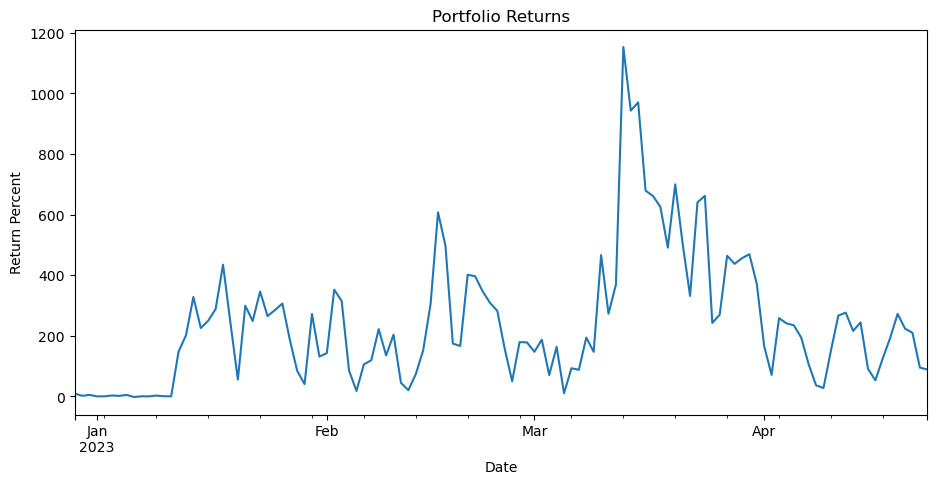

In [10]:
profits_df["Return Percent"] = (profits_df["Profit"]/30_000)*100
plt.title('Portfolio Returns')
profits_df["Return Percent"].plot(figsize=(11,5))
plt.xlabel('Date')
plt.ylabel('Return Percent')
plt.show()

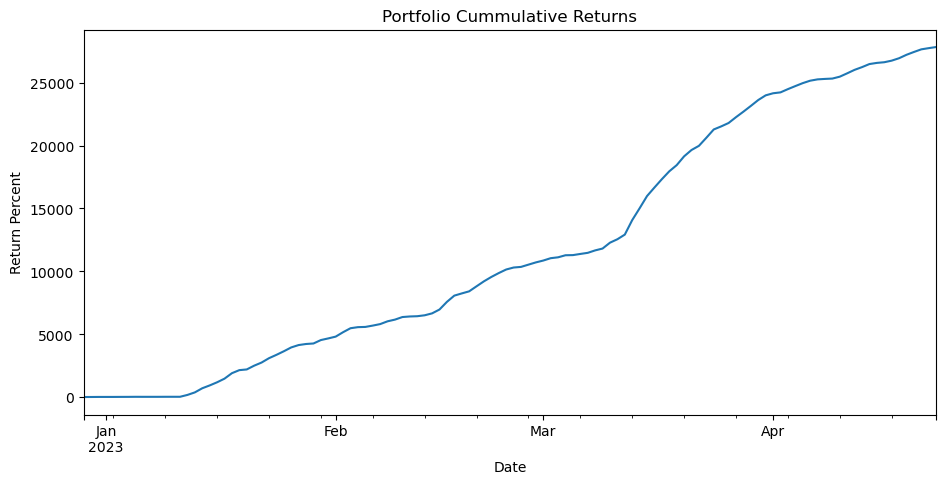

In [11]:
plt.title('Portfolio Cummulative Returns')
profits_df["Return Percent"].cumsum().plot(figsize=(11,5))
plt.xlabel('Date')
plt.ylabel('Return Percent')
plt.show()

### Sharpe Ratio and Daily Drawdown

In [12]:
def calculate_sharpe_ratio(returns_data, risk_free_rate):
    
    # Calculate portfolio returns and volatility
    portfolio_returns = np.mean(returns_data)
    portfolio_volatility = np.std(returns_data)

    # Calculate excess returns
    excess_returns = portfolio_returns - risk_free_rate

    # Calculate Sharpe ratio
    sharpe_ratio = excess_returns / portfolio_volatility

    return sharpe_ratio

In [13]:
display("Sharpe Ratio of the Portfolio is:", calculate_sharpe_ratio(profits_df["Return Percent"], 4.5))

'Sharpe Ratio of the Portfolio is:'

1.0955181252157968

Although, the strategy seems quite successfull, there is a lot of volatilty in the returns, the returns range from less than 5 percent to greater than 500, and therefore the sharpe ratio is rather low.

In [14]:
np.std(profits_df["Return Percent"])

214.8700861470263

### Given the dataset, I have chosen a rolling window of 7 days to calculate the daily drawdowns.

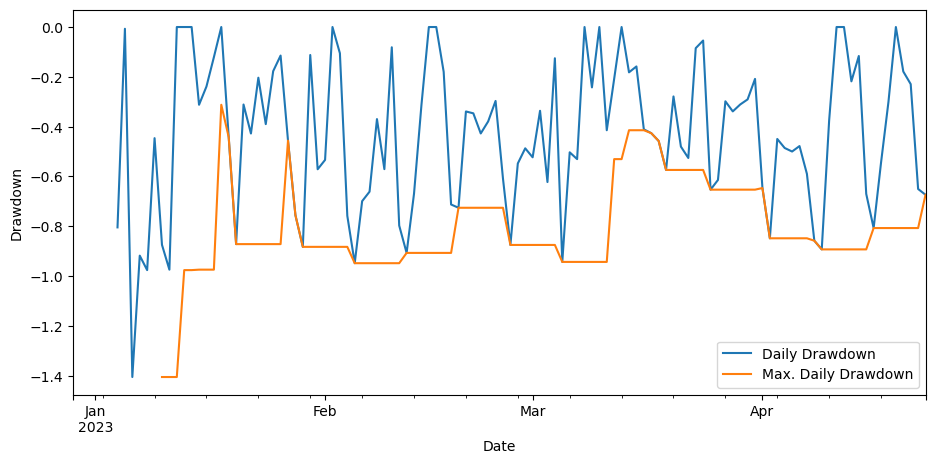

In [15]:
# We are going to use a trailing 1 trading day window
window = 7

# Calculate the max drawdown in the past window days for each day in the series.
Roll_Max = profits_df["Return Percent"].rolling(window).max()
Daily_Drawdown = profits_df["Return Percent"]/Roll_Max - 1.0

# Next we calculate the minimum (negative) daily drawdown in that window.
# Again, use min_periods=1 if you want to allow the expanding window
Max_Daily_Drawdown = Daily_Drawdown.rolling(window).min()

# Plot the results
Daily_Drawdown.plot(figsize=(11,5), label='Daily Drawdown')
Max_Daily_Drawdown.plot(figsize=(11,5), label='Max. Daily Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()
plt.show()